# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [ ]:
#!pip install -qU ragas==0.2.10

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.7/175.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/1

In [ ]:
#!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [1]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

We'll also want to set a project name to make things easier for ourselves.

In [2]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [3]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [4]:
!mkdir data

In [5]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31287    0 31287    0     0  92995      0 --:--:-- --:--:-- --:--:-- 92839


In [6]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70146    0 70146    0     0   182k      0 --:--:-- --:--:-- --:--:--  183k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [4]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

[nltk_data] Downloading package punkt to /Users/dragos/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dragos/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [5]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

/Users/dragos/Development/aibootcamp/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/segmenter.py:66: SyntaxWarning: invalid escape sequence '\s'
  for match in re.finditer('{0}\s*'.format(re.escape(sent)), self.original_text):
/Users/dragos/Development/aibootcamp/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/arabic.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)
/Users/dragos/Development/aibootcamp/AIE5/07_Synthetic_Data_Generation_and_LangSmith/.venv/lib/python3.13/site-packages/pysbd/lang/persian.py:29: SyntaxWarning: invalid escape sequence '\.'
  txt = re.sub('(?<={0})\.'.format(am), '∯', txt)


Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [7]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [8]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [9]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 68)

We can save and load our knowledge graphs as follows.

In [11]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 68)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [12]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [13]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


From RAGAS docs ::
https://docs.ragas.io/en/stable/concepts/test_data_generation/rag/#single-hop-query

SingleHopSpecificQuerySynthesizer :: A single-hop query is a straightforward question that requires retrieving information from a single document or source to provide a relevant answer. It involves only one step to arrive at the answer.

A multi-hop query involves multiple steps of reasoning, requiring information from two or more sources. The system must retrieve information from various documents and connect the dots to generate an accurate answer.

MultiHopAbstractQuerySynthesizer
Requires the retrieval of multiple pieces of information over time and across different sources to form a broad, interpretive response about the evolution of the theory.

MultiHopSpecificQuerySynthesizer
Requires the system to retrieve information about both the scientist who influenced Einstein and the specific theory, potentially from two different sources.



Finally, we can use our `TestSetGenerator` to generate our testset!

In [14]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,"Wht are the key learnings about LLMs in 2024, ...",[Code may be the best application The ethics o...,"In 2024, we learned that Large Language Models...",single_hop_specifc_query_synthesizer
1,What ChatGPT Code Interpreter do?,[Based Development As a computer scientist and...,The ChatGPT Code Interpreter allows the LLM to...,single_hop_specifc_query_synthesizer
2,What AI stuff start in 1950s?,[Simon Willison’s Weblog Subscribe Stuff we fi...,The academic field of Artificial Intelligence ...,single_hop_specifc_query_synthesizer
3,what is impact of llms on jobs and society?,[easy to follow. The rest of the document incl...,The impact of LLMs on human society is already...,single_hop_specifc_query_synthesizer
4,What role does Meta play in the advancements o...,[Prompt driven app generation is a commodity a...,Meta is one of the 18 organizations with model...,single_hop_specifc_query_synthesizer
5,How have the model training costs and environm...,[<1-hop>\n\nCode may be the best application T...,The model training costs for large language mo...,multi_hop_abstract_query_synthesizer
6,What are the implications of the reduced model...,[<1-hop>\n\nCode may be the best application T...,The reduction in model training costs has sign...,multi_hop_abstract_query_synthesizer
7,How does the black box nature of Large Languag...,[<1-hop>\n\nCode may be the best application T...,The black box nature of Large Language Models ...,multi_hop_abstract_query_synthesizer
8,How has Meta's release of Llama and Llama 2 in...,[<1-hop>\n\nCode may be the best application T...,Meta's release of Llama and Llama 2 has signif...,multi_hop_specific_query_synthesizer
9,How have the advancements in large language mo...,[<1-hop>\n\nneeds guidance. Those of us who un...,"Advancements in large language models, includi...",multi_hop_specific_query_synthesizer


### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [15]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [16]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Wut has Microsoft Research dun in the feeld of...,[Code may be the best application The ethics o...,Microsoft Research has produced better-than-GP...,single_hop_specifc_query_synthesizer
1,ChatGPT get lazy in December?,[Based Development As a computer scientist and...,The honest answer is 'maybe'! No-one is entire...,single_hop_specifc_query_synthesizer
2,What were the key developments in AI in 2023?,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,what stable diffusion mean in context of large...,[easy to follow. The rest of the document incl...,The context mentions that large language model...,single_hop_specifc_query_synthesizer
4,How have the training costs and environmental ...,[<1-hop>\n\nCode may be the best application T...,The training costs for Large Language Models (...,multi_hop_abstract_query_synthesizer
5,What are the implications of model training co...,[<1-hop>\n\nCode may be the best application T...,The development of Large Language Models (LLMs...,multi_hop_abstract_query_synthesizer
6,How have the training costs and environmental ...,[<1-hop>\n\nCode may be the best application T...,The training costs for Large Language Models (...,multi_hop_abstract_query_synthesizer
7,How does the black box nature of Large Languag...,[<1-hop>\n\nCode may be the best application T...,The black box nature of Large Language Models ...,multi_hop_abstract_query_synthesizer
8,How did Google's advancements in large languag...,[<1-hop>\n\neasy to follow. The rest of the do...,Google's advancements in large language models...,multi_hop_specific_query_synthesizer
9,How has Mistral contributed to the advancement...,[<1-hop>\n\nCode may be the best application T...,Mistral has significantly contributed to the a...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [17]:
from langsmith import Client

client = Client()

dataset_name = "State of AI Across the Years!"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years!"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [18]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [19]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [20]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [21]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [22]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [23]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [24]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [25]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [26]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [27]:
rag_chain.invoke({"question" : "What are Agents?"})

'"Agents" refer to AI systems that can act on your behalf, but the term is considered frustratingly vague and lacks a single, clear definition. There are differing interpretations, with some viewing agents as automated systems similar to travel agents, while others think of them as large language models (LLMs) using tools to solve problems. Despite excitement around the concept, there are few examples of such agents running in production. The concept of agents is often linked to the idea of autonomy, but skepticism remains regarding their utility, mainly due to challenges such as gullibility.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [28]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [29]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.
A string evaluator is a component within LangChain designed to assess the performance of a language model by comparing its generated outputs (predictions) to a reference string or an input. 

- `qa_evaluator`: quality 
- `labeled_helpfulness_evaluator`: if the user found this helpful or not
- `dope_or_nope_evaluator`: How dope the submssion was based on three categorical values: dope, lit or cool

## LangSmith Evaluation

In [30]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'extraneous-kick-74' at:
https://smith.langchain.com/o/a320afef-b11f-4c66-a139-6c7fa694488d/datasets/e8ad5a96-d621-419a-8e86-70d0220a3618/compare?selectedSessions=a798283d-e388-41a2-aaf7-1c0b202d104c




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,What were some of the key advancements and cha...,"In 2023, some key advancements in the developm...",None,"In 2023, Large Language Models (LLMs) experien...",1,0,1,3.476348,d2177f59-2278-42a4-80b6-e526abf459b0,2b429c23-86d8-4e09-b613-edc3b71dbe95
1,"How did the advancements in LLMs in 2024, part...","The advancements in LLMs in 2024, particularly...",None,"In 2024, advancements in LLMs led to significa...",0,0,1,2.350951,630e10b1-e3fd-4942-97aa-6ce4805d8665,a0a788af-8a00-4571-b502-f8b25e02d6d6
2,How has Mistral contributed to the advancement...,I don't know.,None,Mistral has significantly contributed to the a...,0,0,0,2.148182,92a8a845-ac92-42f4-8b74-31beccb21b84,50424044-e67f-4fc4-99d8-fe5a7d51391b
3,How did Google's advancements in large languag...,Google's advancements in large language models...,None,Google's advancements in large language models...,1,1,1,3.535986,16bb0f2e-4a50-44ab-9aed-da5ba91e48a2,0db6e6de-e8b9-4278-9380-387fb4dce48c
4,How does the black box nature of Large Languag...,The black box nature of Large Language Models ...,None,The black box nature of Large Language Models ...,1,0,0,2.760929,aa6b6d7d-1613-4d7e-afc3-ca87e28765d9,6f55259e-626d-438c-9bf4-aa8cb8033579
5,How have the training costs and environmental ...,The training costs for Large Language Models (...,None,The training costs for Large Language Models (...,1,0,0,3.758699,c8cfd1ba-8577-4a8b-8d46-e938ee1eb017,99b48a5e-f2e8-4f8a-b5eb-deaa182e00f5
6,What are the implications of model training co...,The implications of model training costs and e...,None,The development of Large Language Models (LLMs...,1,0,0,3.062920,517dc227-9a4a-4130-818a-69dcd2234988,b062f9d5-6695-487f-bbce-01b586752196
7,How have the training costs and environmental ...,The training costs for Large Language Models (...,None,The training costs for Large Language Models (...,1,0,0,3.174995,ae7997d2-d68e-477e-acc0-69ab2427b477,63886af0-cda6-408a-b3b3-4667961f2578
8,what stable diffusion mean in context of large...,I don't know.,None,The context mentions that large language model...,0,0,0,1.196800,e0cea07f-9c28-4234-8072-7c755550b775,6704a938-50a7-4377-89c1-138ce2fc505b
9,What were the key developments in AI in 2023?,The key developments in AI in 2023 included th...,None,2023 was the breakthrough year for Large Langu...,1,0,1,2.787610,dcbabfdf-d7fa-4e41-9995-ea9d7d1809e3,59172a0b-0bc1-44c2-8f37-1d1067d05234


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [31]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [32]:
rag_documents = docs

In [33]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

It impacts the ability to retrieve relevant informnation, if chunks are too small they may lose important context, if too large they may contain irrelevant information thus making overall process less efficient.

In [34]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

Embedding model relates to how well the system is able to retrieve relevant documents, i.e. precision. This is turn will affect the quality of the LLM responses.

In [35]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [36]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [37]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [38]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

'Agents, my friend, are basically these vague, buzzwordy AI systems that are supposed to act on your behalf. You’ve got folks seeing them as travel agents ready to book your trips or as LLMs harnessing tools to solve problems. But here’s the kicker: the term is confusing, with no clear definitions flying around. They’re like the cool concept that everyone’s talking about but haven\'t quite delivered on—still chilling in the "coming soon" zone! Plus, there\'s a biggie issue with gullibility, making it tough for these agents to truly deliver. So, in a nutshell, agents are the future we’re all kinda waiting on!'

Finally, we can evaluate the new chain on the same test set!

In [39]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'stupendous-swim-10' at:
https://smith.langchain.com/o/a320afef-b11f-4c66-a139-6c7fa694488d/datasets/e8ad5a96-d621-419a-8e86-70d0220a3618/compare?selectedSessions=5028ba0f-f3d3-43b3-b351-5f6facc3636c




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,What were some of the key advancements and cha...,"Yo, 2023 was a wild ride for Large Language Mo...",None,"In 2023, Large Language Models (LLMs) experien...",1,0,1,3.309827,d2177f59-2278-42a4-80b6-e526abf459b0,9f2b4771-036d-475f-b354-73efc2314eb2
1,"How did the advancements in LLMs in 2024, part...","Yo, in 2024, the game changed big time for LLM...",None,"In 2024, advancements in LLMs led to significa...",1,0,1,3.096741,630e10b1-e3fd-4942-97aa-6ce4805d8665,4940cb79-4f1c-42ca-ac41-05aa6c27d3f6
2,How has Mistral contributed to the advancement...,I don't know.,None,Mistral has significantly contributed to the a...,0,0,0,3.611094,92a8a845-ac92-42f4-8b74-31beccb21b84,6e0838f1-1318-48bf-b802-40c73adc9509
3,How did Google's advancements in large languag...,"Yo, Google's moves with the Gemini 1.5 Pro tot...",None,Google's advancements in large language models...,1,1,1,3.529532,16bb0f2e-4a50-44ab-9aed-da5ba91e48a2,6a6ee2e0-32d2-4f71-8f11-2706d77bf7f2
4,How does the black box nature of Large Languag...,"Alright, let’s break it down! The black box na...",None,The black box nature of Large Language Models ...,1,0,1,6.656216,aa6b6d7d-1613-4d7e-afc3-ca87e28765d9,3865ca3f-2fa3-4b33-9b31-9a3cc740c2bd
5,How have the training costs and environmental ...,"Yo, the training costs for Large Language Mode...",None,The training costs for Large Language Models (...,1,0,1,5.282430,c8cfd1ba-8577-4a8b-8d46-e938ee1eb017,b40c0dde-5f93-44a5-b203-cd69ac2b31f8
6,What are the implications of model training co...,"Yo, the implications of model training costs a...",None,The development of Large Language Models (LLMs...,1,0,1,2.860430,517dc227-9a4a-4130-818a-69dcd2234988,0e7043c0-1f72-4cdd-bb59-15d824038fe3
7,How have the training costs and environmental ...,"Yo, check it out! Training costs for Large Lan...",None,The training costs for Large Language Models (...,1,0,1,3.571834,ae7997d2-d68e-477e-acc0-69ab2427b477,9dd215f6-cb97-401d-b456-eb39c87a94f2
8,what stable diffusion mean in context of large...,"Yo, ""stable diffusion"" in the context of large...",None,The context mentions that large language model...,1,0,1,6.220180,e0cea07f-9c28-4234-8072-7c755550b775,75e30618-351a-4fd8-9f21-e6d2c35de43f
9,What were the key developments in AI in 2023?,"In 2023, it was all about those Large Language...",None,2023 was the breakthrough year for Large Langu...,1,1,1,3.220502,dcbabfdf-d7fa-4e41-9995-ea9d7d1809e3,ca4f0b53-4968-4d23-8f0c-3d5b9d040814


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

First run:

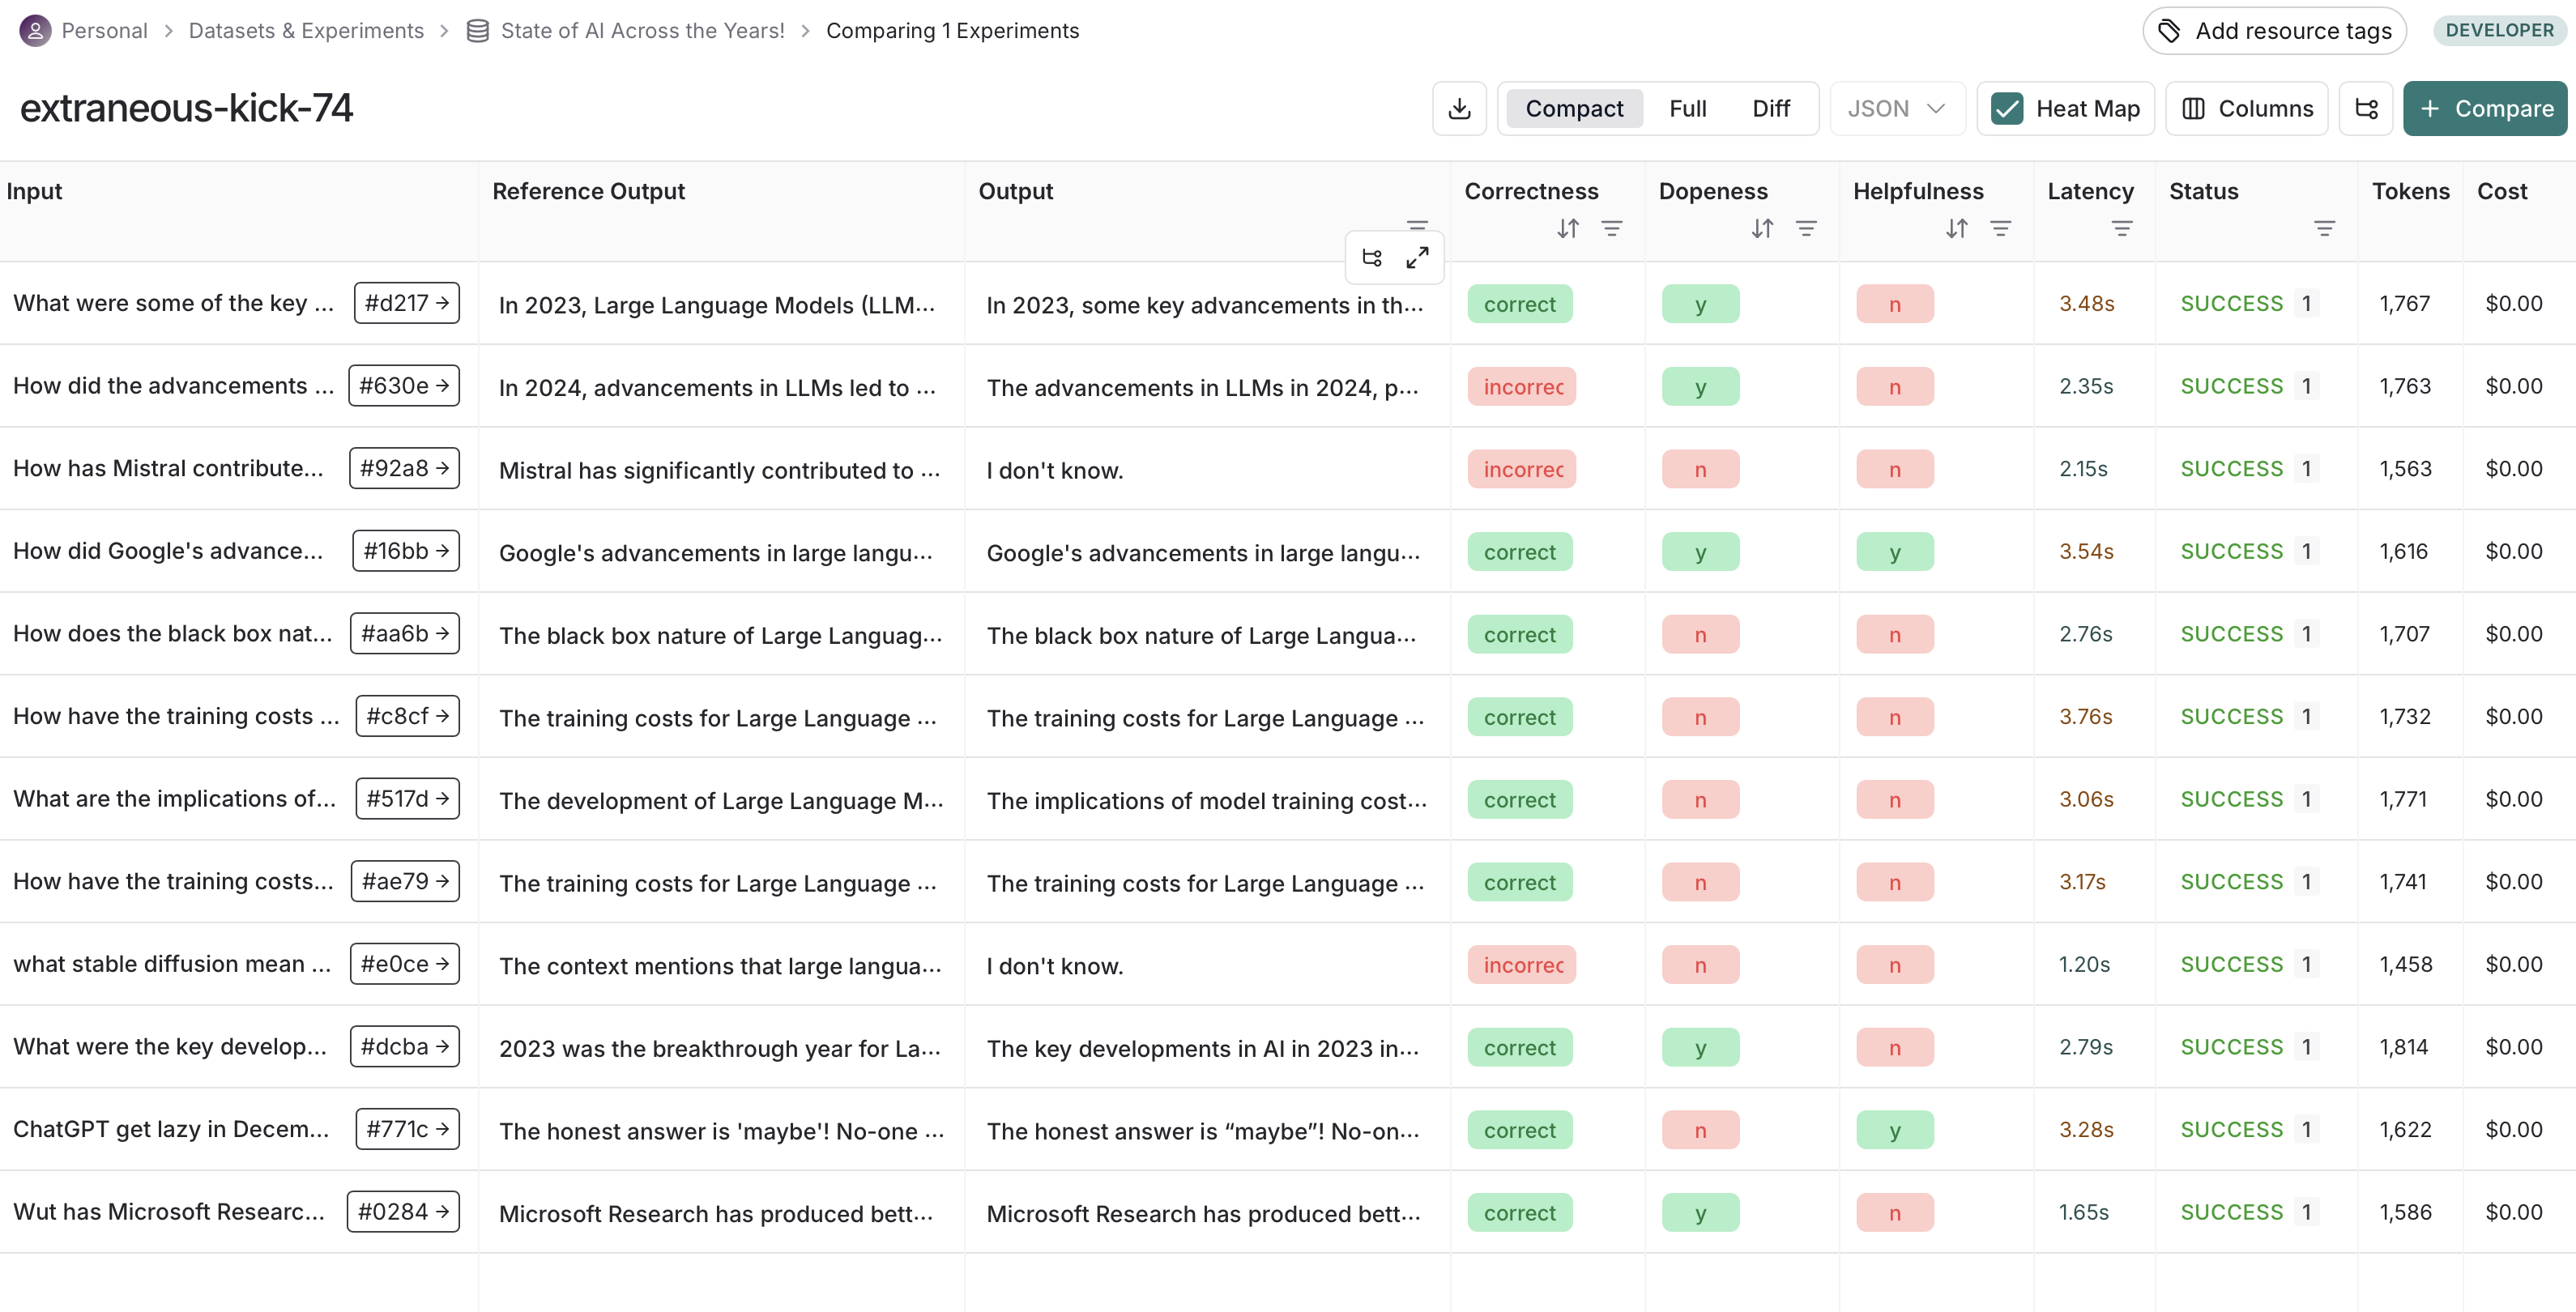

Second run:

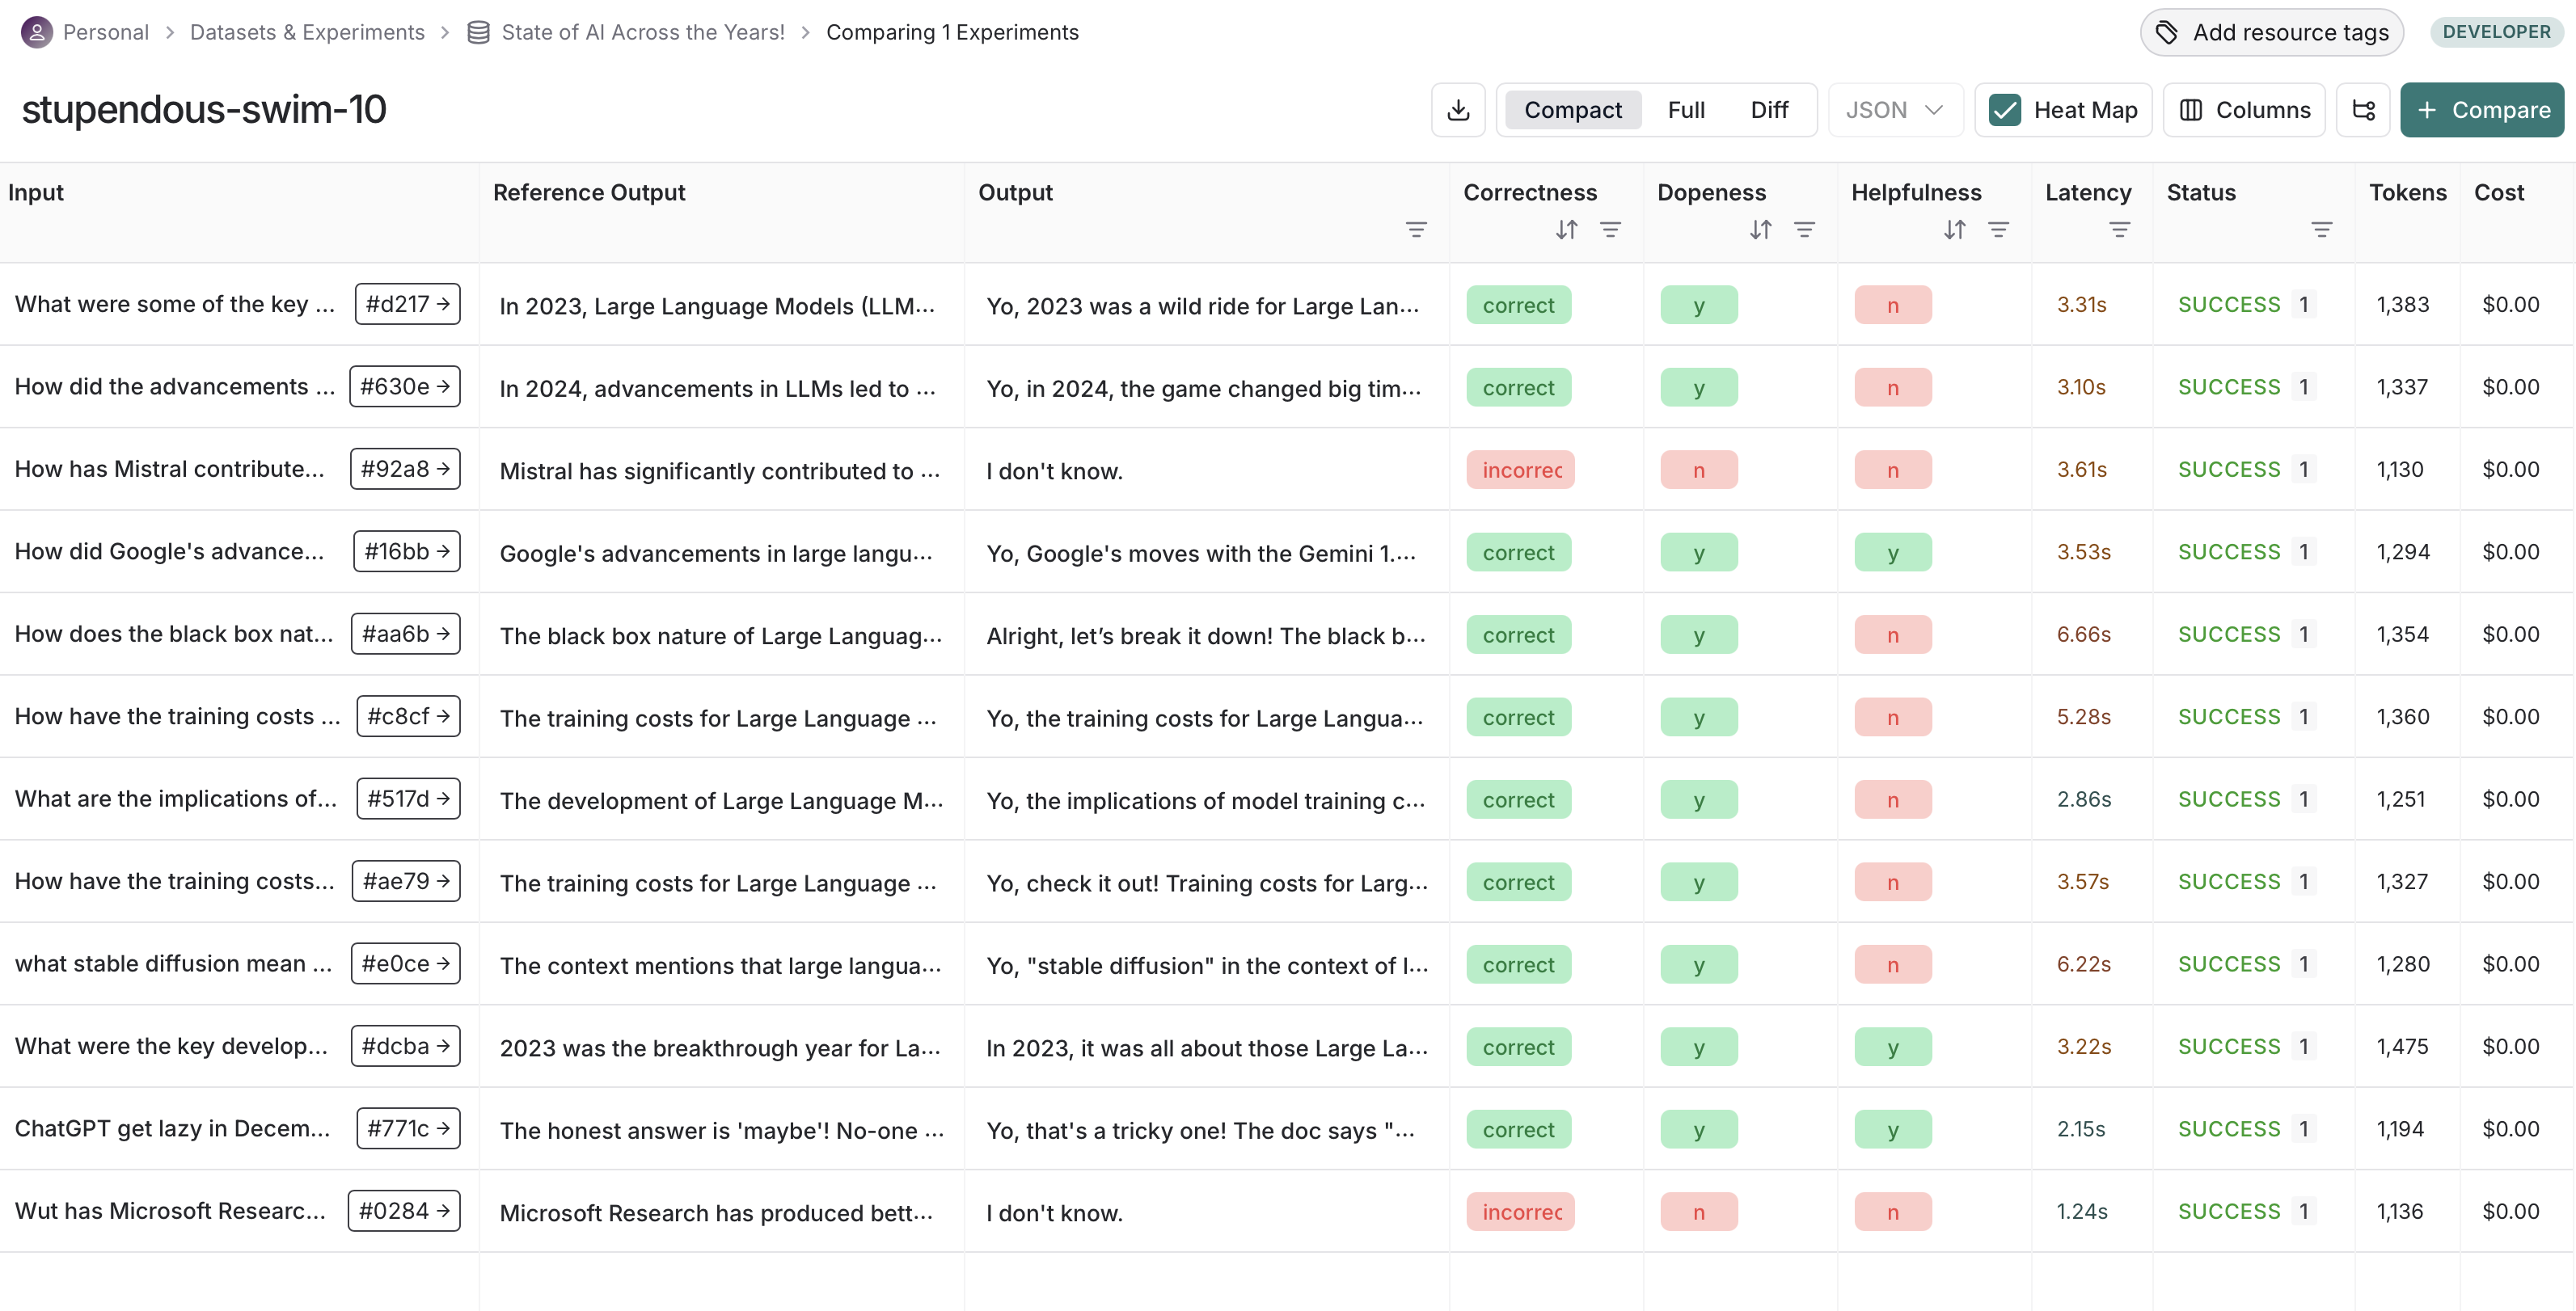